## Uploading my environment package which I created and deployed on github

In [ ]:
# Install required packages
!pip install stable-baselines3[extra]==2.0.0 gymnasium>=0.28.1 numpy>=1.24.0 \
    pygame>=2.1.0 torch>=2.0.0 tensorboard>=2.12.0 matplotlib>=3.7.0 \
    tqdm>=4.65.0 seaborn>=0.12.0 git+https://github.com/Tripp808/maternal_care.git # my packaged environment

  Running command git clone --filter=blob:none --quiet https://github.com/Tripp808/maternal_care.git /tmp/pip-req-build-9xeigaok


In [ ]:
# libraries used
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm.notebook import tqdm
import torch
import gymnasium as gym
from IPython.display import clear_output

# Import environment
from maternal_care import MaternalCareEnv

# the directories for saving results
os.makedirs("logs", exist_ok=True)
os.makedirs("models", exist_ok=True)
os.makedirs("visualizations", exist_ok=True)

# the device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

/usr/local/lib/python3.11/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-pa

Using device: cuda


## Testing Environment

In [ ]:
def test_environment():
    """Test if the environment can be created and used"""
    env = MaternalCareEnv(mode='delivery')
    print(f"Action space: {env.action_space}")
    print(f"Observation space: {env.observation_space}")

    obs, info = env.reset()
    print(f"Initial observation shape: {obs.shape}")

    # Take a random action
    action = env.action_space.sample()
    next_obs, reward, terminated, truncated, info = env.step(action)

    print(f"Next observation shape: {next_obs.shape}")
    print(f"Reward: {reward}")
    print(f"Terminated: {terminated}")
    print(f"Truncated: {truncated}")

    env.close()
    print("Environment test successful!")

test_environment()

Action space: Discrete(4)
Observation space: Box(-inf, inf, (14,), float32)
Initial observation shape: (14,)
Next observation shape: (14,)
Reward: -0.11
Terminated: False
Truncated: False
Environment test successful!


## Callbacks and Helper Functions

In [ ]:
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback, CheckpointCallback
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3 import DQN, PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import SubprocVecEnv, DummyVecEnv

class TrainingProgressCallback(BaseCallback):
    """
    Custom callback for plotting training progress in real-time
    """
    def __init__(self, check_freq=1000, log_dir=None, verbose=1):
        super(TrainingProgressCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'training_progress')
        self.x = []
        self.y = []
        self.best_mean_reward = -np.inf

    def _init_callback(self):
        # Create folder only if i need
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), 'timesteps')
            if len(x) > 0:
                # Update lists
                self.x.extend(x[-self.check_freq:])
                self.y.extend(y[-self.check_freq:])

                # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])

                # New best model, save the agent
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward

                # Plot training progress
                self._plot_training_progress()

                if self.verbose > 0:
                    print(f"Timestep: {self.num_timesteps}")
                    print(f"Mean reward: {mean_reward:.2f}")
                    print(f"Best mean reward: {self.best_mean_reward:.2f}")

        return True

    def _plot_training_progress(self):
        """
        Plot training progress and save to file
        """
        plt.figure(figsize=(10, 6))
        plt.plot(self.x, self.y)
        plt.xlabel('Timesteps')
        plt.ylabel('Rewards')
        plt.title('Training Progress')
        plt.savefig(os.path.join(self.save_path, f'training_progress_{self.num_timesteps}.png'))
        plt.close()

def make_env(mode, cheat_code=None, seed=0, log_dir=None):
    """
    Utility function for multiprocessed env
    """
    def _init():
        env = MaternalCareEnv(mode=mode, cheat_code=cheat_code)
        env.reset(seed=seed)
        if log_dir is not None:
            # Create unique log dir for each environment
            env_log_dir = os.path.join(log_dir, f'env_{seed}')
            os.makedirs(env_log_dir, exist_ok=True)
            env = Monitor(env, env_log_dir)
        return env
    return _init

def test_trained_agent(model, env_mode, num_episodes=5):
    """
    Test a trained agent and collect performance metrics
    """
    # Create environment
    env = MaternalCareEnv(mode=env_mode)

    # Collect metrics
    rewards = []
    steps = []
    successes = 0

    for episode in tqdm(range(num_episodes), desc="Testing agent"):
        obs, info = env.reset()
        episode_reward = 0
        episode_steps = 0
        done = False

        while not done:
            # Use the model to predict the action
            action, _ = model.predict(obs, deterministic=True)

            # Take the action
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            episode_reward += reward
            episode_steps += 1

        # Record metrics
        rewards.append(episode_reward)
        steps.append(episode_steps)
        if episode_reward > 50:  # Assuming success if reward is high
            successes += 1

    # Calculate metrics
    metrics = {
        "mean_reward": float(np.mean(rewards)),
        "std_reward": float(np.std(rewards)),
        "min_reward": float(np.min(rewards)),
        "max_reward": float(np.max(rewards)),
        "mean_steps": float(np.mean(steps)),
        "std_steps": float(np.std(steps)),
        "success_rate": float(successes / num_episodes),
        "num_episodes": num_episodes
    }

    # Display metrics
    print("\nPerformance Metrics:")
    print(f"Mean reward: {metrics['mean_reward']:.2f} ± {metrics['std_reward']:.2f}")
    print(f"Min/Max reward: {metrics['min_reward']:.2f} / {metrics['max_reward']:.2f}")
    print(f"Mean steps: {metrics['mean_steps']:.2f} ± {metrics['std_steps']:.2f}")
    print(f"Success rate: {metrics['success_rate']*100:.1f}%")

    env.close()
    return metrics

## DQN Training Function

In [ ]:

def train_dqn_agent(mode='delivery', total_timesteps=100000, eval_freq=10000, seed=42, cheat_code=None):
    """
    Train a DQN agent for the maternal care environment

    Args:
        mode: 'delivery' or 'emergency'
        total_timesteps: total training steps
        eval_freq: evaluation frequency
        seed: random seed for reproducibility
        cheat_code: optional cheat code for training assistance
    """
    # Set random seed
    set_random_seed(seed)

    # Create log directory
    run_id = int(time.time())
    log_dir = f"./logs/{mode}_dqn_{run_id}/"
    os.makedirs(log_dir, exist_ok=True)

    # Create and wrap the environment
    env = MaternalCareEnv(mode=mode, cheat_code=cheat_code)
    env = Monitor(env, log_dir)

    # Create evaluation environment (without rendering)
    eval_env = MaternalCareEnv(mode=mode)
    eval_env = Monitor(eval_env, os.path.join(log_dir, 'eval'))

    # Create callbacks
    eval_callback = EvalCallback(
        eval_env,
        best_model_save_path=log_dir,
        log_path=log_dir,
        eval_freq=eval_freq,
        deterministic=True,
        render=False
    )

    # Checkpoint callback to save models periodically
    checkpoint_callback = CheckpointCallback(
        save_freq=eval_freq,
        save_path=os.path.join(log_dir, 'checkpoints'),
        name_prefix=f"dqn_{mode}"
    )

    # Training progress callback
    progress_callback = TrainingProgressCallback(
        check_freq=1000,
        log_dir=log_dir
    )

    # Create the DQN agent with optimized hyperparameters
    model = DQN(
        "MlpPolicy",
        env,
        learning_rate=3e-4,
        buffer_size=100000,
        learning_starts=1000,
        batch_size=128,
        gamma=0.99,
        exploration_fraction=0.3,  # Longer exploration
        exploration_initial_eps=1.0,
        exploration_final_eps=0.05,
        train_freq=4,
        gradient_steps=1,
        target_update_interval=1000,
        verbose=1,
        tensorboard_log=log_dir,
        device=device
    )

    # Save training parameters for reference
    training_params = {
        "mode": mode,
        "total_timesteps": total_timesteps,
        "seed": seed,
        "learning_rate": model.learning_rate,
        "buffer_size": model.buffer_size,
        "batch_size": model.batch_size,
        "gamma": model.gamma,
        "exploration_fraction": model.exploration_fraction,
        "exploration_initial_eps": model.exploration_initial_eps,
        "exploration_final_eps": model.exploration_final_eps,
        "train_freq": model.train_freq.frequency,
        "target_update_interval": model.target_update_interval,
        "cheat_code": cheat_code,
        "start_time": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    }

    # Save parameters to file
    import json
    with open(os.path.join(log_dir, 'training_params.json'), 'w') as f:
        json.dump(training_params, f, indent=4)

    # Train the agent
    print(f"Training DQN agent in {mode} mode for {total_timesteps} steps...")
    print(f"Training logs saved to {log_dir}")
    print(f"Using cheat code: {cheat_code}" if cheat_code else "No cheat codes used")

    # Start training with all callbacks
    model.learn(
        total_timesteps=total_timesteps,
        callback=[eval_callback, checkpoint_callback, progress_callback]
    )

    # Save the final trained model
    model_path = os.path.join(log_dir, f"dqn_{mode}_final.zip")
    model.save(model_path)
    print(f"Final model saved to {model_path}")

    # Record training end time
    with open(os.path.join(log_dir, 'training_params.json'), 'r') as f:
        params = json.load(f)

    params["end_time"] = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    # Calculate training duration
    start_time = datetime.strptime(params["start_time"], "%Y-%m-%d %H:%M:%S")
    end_time = datetime.strptime(params["end_time"], "%Y-%m-%d %H:%M:%S")
    duration = end_time - start_time
    params["duration"] = str(duration)

    # Save updated parameters
    with open(os.path.join(log_dir, 'training_params.json'), 'w') as f:
        json.dump(params, f, indent=4)

    # Final evaluation
    print("Performing final evaluation...")
    mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=20, deterministic=True)
    print(f"Final evaluation: Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

    # Save evaluation results
    eval_results = {
        "mean_reward": float(mean_reward),
        "std_reward": float(std_reward),
        "n_eval_episodes": 20
    }

    with open(os.path.join(log_dir, 'final_evaluation.json'), 'w') as f:
        json.dump(eval_results, f, indent=4)

    return model, log_dir

## PPO Training Function

In [ ]:

from stable_baselines3.common.vec_env import VecMonitor, SubprocVecEnv
from stable_baselines3.common.monitor import Monitor

def train_ppo_agent(mode='delivery', total_timesteps=100000, eval_freq=10000, seed=42, cheat_code=None, n_envs=4):
    """Train a PPO agent for the maternal care environment"""
    # Set random seed
    set_random_seed(seed)

    # Create log directory
    run_id = int(time.time())
    log_dir = f"./logs/{mode}_ppo_{run_id}/"
    os.makedirs(log_dir, exist_ok=True)

    # 1. Create vectorized training environments with VecMonitor
    env = SubprocVecEnv([make_env(mode, cheat_code, seed + i) for i in range(n_envs)])
    env = VecMonitor(env, log_dir)  # Vectorized monitor for training

    # Create single evaluation environment with regular Monitor
    eval_env = MaternalCareEnv(mode=mode)
    eval_log_dir = os.path.join(log_dir, 'eval')
    os.makedirs(eval_log_dir, exist_ok=True)
    eval_env = Monitor(eval_env, eval_log_dir)

    # Create callbacks
    eval_callback = EvalCallback(
        eval_env,
        best_model_save_path=log_dir,
        log_path=log_dir,
        eval_freq=eval_freq // n_envs,  # Adjust for vectorized env
        deterministic=True,
        render=False
    )

    # Checkpoint callback to save models periodically
    checkpoint_callback = CheckpointCallback(
        save_freq=eval_freq // n_envs,
        save_path=os.path.join(log_dir, 'checkpoints'),
        name_prefix=f"ppo_{mode}"
    )

    # Create the PPO agent with optimized hyperparameters
    model = PPO(
        "MlpPolicy",
        env,
        learning_rate=3e-4,
        n_steps=2048,
        batch_size=64,
        n_epochs=10,
        gamma=0.99,
        gae_lambda=0.95,
        clip_range=0.2,
        ent_coef=0.01,  # to encourage exploration
        vf_coef=0.5,
        max_grad_norm=0.5,
        verbose=1,
        tensorboard_log=log_dir,
        device=device
    )

    # Save training parameters for reference
    training_params = {
        "mode": mode,
        "total_timesteps": total_timesteps,
        "seed": seed,
        "n_envs": n_envs,
        "learning_rate": float(model.learning_rate) if callable(model.learning_rate) else model.learning_rate,
        "n_steps": model.n_steps,
        "batch_size": model.batch_size,
        "n_epochs": model.n_epochs,
        "gamma": model.gamma,
        "gae_lambda": model.gae_lambda,
        "clip_range": model.clip_range,
        "ent_coef": model.ent_coef,
        "vf_coef": model.vf_coef,
        "cheat_code": cheat_code,
        "start_time": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    }

    # Before saving i wanna make sure all values are JSON serializable:
    for key, value in training_params.items():
        if callable(value):
            training_params[key] = str(value)  # Convert functions to strings

    import json
    with open(os.path.join(log_dir, 'training_params.json'), 'w') as f:
        json.dump(training_params, f, indent=4)

    # Train the agent
    print(f"Training PPO agent in {mode} mode for {total_timesteps} steps with {n_envs} parallel environments...")
    print(f"Training logs saved to {log_dir}")
    print(f"Using cheat code: {cheat_code}" if cheat_code else "No cheat codes used")

    # Start training with callbacks
    model.learn(
        total_timesteps=total_timesteps,
        callback=[eval_callback, checkpoint_callback]
    )

    # Save the final trained model
    model_path = os.path.join(log_dir, f"ppo_{mode}_final.zip")
    model.save(model_path)
    print(f"Final model saved to {model_path}")

    # Record training end time
    with open(os.path.join(log_dir, 'training_params.json'), 'r') as f:
        params = json.load(f)

    params["end_time"] = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    # Calculate training duration
    start_time = datetime.strptime(params["start_time"], "%Y-%m-%d %H:%M:%S")
    end_time = datetime.strptime(params["end_time"], "%Y-%m-%d %H:%M:%S")
    duration = end_time - start_time
    params["duration"] = str(duration)

    # Save updated parameters
    with open(os.path.join(log_dir, 'training_params.json'), 'w') as f:
        json.dump(params, f, indent=4)

    # Final evaluation
    print("Performing final evaluation...")
    model_for_eval = PPO.load(model_path, device=device)
    mean_reward, std_reward = evaluate_policy(model_for_eval, eval_env, n_eval_episodes=20, deterministic=True)
    print(f"Final evaluation: Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

    # Save evaluation results
    eval_results = {
        "mean_reward": float(mean_reward),
        "std_reward": float(std_reward),
        "n_eval_episodes": 20
    }

    with open(os.path.join(log_dir, 'final_evaluation.json'), 'w') as f:
        json.dump(eval_results, f, indent=4)

    # Close environments
    env.close()
    eval_env.close()

    return model_path, log_dir

## Visualization Functions

In [ ]:
def compare_models(models_info, mode='delivery', num_episodes=20):
    """
    Compare multiple trained models and visualize their performance

    Args:
        models_info: List of (model, model_name, model_type) tuples
        mode: Environment mode
        num_episodes: Number of episodes for evaluation
    """
    # Setup data collection
    all_metrics = []

    # Test each model
    for model, model_name, model_type in models_info:
        print(f"\nEvaluating model: {model_name}")

        # Collect metrics
        metrics = test_trained_agent(model, mode, num_episodes)
        metrics["model_name"] = model_name
        metrics["model_type"] = model_type

        all_metrics.append(metrics)

    # Create visualizations
    create_comparison_plots(all_metrics, mode)

    return all_metrics

def create_comparison_plots(metrics, mode):
    """
    Create comparison plots for all models

    Args:
        metrics: List of metrics dictionaries
        mode: Environment mode
    """
    import seaborn as sns
    # Set up the style
    sns.set(style="whitegrid")
    plt.figure(figsize=(15, 10))

    # Extract data
    model_names = [m["model_name"] for m in metrics]
    mean_rewards = [m["mean_reward"] for m in metrics]
    std_rewards = [m["std_reward"] for m in metrics]
    success_rates = [m["success_rate"] * 100 for m in metrics]
    mean_steps = [m["mean_steps"] for m in metrics]

    # Create subplots
    plt.subplot(2, 2, 1)
    plt.bar(model_names, mean_rewards, yerr=std_rewards, capsize=10)
    plt.title('Mean Reward by Model')
    plt.ylabel('Mean Reward')
    plt.xticks(rotation=45)

    plt.subplot(2, 2, 2)
    plt.bar(model_names, success_rates)
    plt.title('Success Rate by Model')
    plt.ylabel('Success Rate (%)')
    plt.xticks(rotation=45)

    plt.subplot(2, 2, 3)
    plt.bar(model_names, mean_steps)
    plt.title('Mean Steps by Model')
    plt.ylabel('Mean Steps')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.savefig(f'visualizations/model_comparison_{mode}.png')

    # Display the plot
    plt.show()

def plot_learning_curves(log_dirs):
    """
    Plot learning curves from training logs

    Args:
        log_dirs: List of (log_directory, label) tuples
    """
    plt.figure(figsize=(12, 8))

    for log_dir, label in log_dirs:
        # Try to load the monitor file
        try:
            # First try to load numpy format
            try:
                data = np.load(os.path.join(log_dir, 'monitor.npz'))
                x, y = data['t'], data['r']
            except:
                # If that fails, try CSV format
                data = np.genfromtxt(os.path.join(log_dir, 'monitor.csv'), delimiter=',', skip_header=1)
                x, y = data[:, 1], data[:, 0]  # Timesteps, Rewards

            # Plot the data
            plt.plot(x, y, label=label)

        except Exception as e:
            print(f"Could not load data from {log_dir}: {e}")

    plt.xlabel('Timesteps')
    plt.ylabel('Rewards')
    plt.title('Learning Curves')
    plt.legend()
    plt.grid(True)

    # Save and show the figure
    plt.savefig("visualizations/learning_curves.png")
    plt.show()

## Train DQN Agent


In [ ]:
# Set training parameters
dqn_timesteps = 100000  # i can increase this for better performance
dqn_mode = 'delivery'   # 'delivery' or 'emergency'
dqn_eval_freq = 5000
dqn_seed = 42
dqn_cheat = None  # Optional for now: 'pathfinder', 'easymode', 'nursefreeze', or 'speedrun'

# Train the DQN agent
dqn_model, dqn_log_dir = train_dqn_agent(
    mode=dqn_mode,
    total_timesteps=dqn_timesteps,
    eval_freq=dqn_eval_freq,
    seed=dqn_seed,
    cheat_code=dqn_cheat
)

Using cuda device
Wrapping the env in a DummyVecEnv.
Training DQN agent in delivery mode for 100000 steps...
Training logs saved to ./logs/delivery_dqn_1743673540/
No cheat codes used
Logging to ./logs/delivery_dqn_1743673540/DQN_1


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/monitor.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_frame = pandas.concat(data_frames)


Timestep: 1000
Mean reward: -10.37
Best mean reward: -10.37
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 300      |
|    ep_rew_mean      | -9.62    |
|    exploration_rate | 0.962    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 837      |
|    time_elapsed     | 1        |
|    total_timesteps  | 1200     |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.0126   |
|    n_updates        | 49       |
----------------------------------


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/monitor.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_frame = pandas.concat(data_frames)


Timestep: 2000
Mean reward: -10.15
Best mean reward: -10.15
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 300      |
|    ep_rew_mean      | -9.74    |
|    exploration_rate | 0.924    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 826      |
|    time_elapsed     | 2        |
|    total_timesteps  | 2400     |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.00536  |
|    n_updates        | 349      |
----------------------------------


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/monitor.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_frame = pandas.concat(data_frames)


Timestep: 3000
Mean reward: -9.11
Best mean reward: -9.11
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 300      |
|    ep_rew_mean      | -9.03    |
|    exploration_rate | 0.886    |
| time/               |          |
|    episodes         | 12       |
|    fps              | 909      |
|    time_elapsed     | 3        |
|    total_timesteps  | 3600     |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.00449  |
|    n_updates        | 649      |
----------------------------------


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/monitor.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_frame = pandas.concat(data_frames)


Streaming output truncated to the last 5000 lines.
| time/               |          |
|    episodes         | 208      |
|    fps              | 791      |
|    time_elapsed     | 36       |
|    total_timesteps  | 28675    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.755    |
|    n_updates        | 6918     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 77.8     |
|    ep_rew_mean      | 96.6     |
|    exploration_rate | 0.0832   |
| time/               |          |
|    episodes         | 212      |
|    fps              | 791      |
|    time_elapsed     | 36       |
|    total_timesteps  | 28951    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.7      |
|    n_updates        | 6987     |
----------------------------------
Timestep: 29000
Mean reward: 96.66
Best mean reward: 97.86
---------------

## Train PPO agent

In [ ]:
# Set training parameters
ppo_timesteps = 100000
ppo_mode = 'delivery'   # 'delivery' or 'emergency'
ppo_eval_freq = 5000
ppo_seed = 42
ppo_cheat = None  # still optional: 'pathfinder', 'easymode', 'nursefreeze', or 'speedrun'
ppo_n_envs = 4    # Number of parallel environments

# Train the PPO agent
ppo_model_path, ppo_log_dir = train_ppo_agent(
    mode=ppo_mode,
    total_timesteps=ppo_timesteps,
    eval_freq=ppo_eval_freq,
    seed=ppo_seed,
    cheat_code=ppo_cheat,
    n_envs=ppo_n_envs
)

# Load the trained PPO model
ppo_model = PPO.load(ppo_model_path, device=device)

Using cuda device
Training PPO agent in delivery mode for 100000 steps with 4 parallel environments...
Training logs saved to ./logs/delivery_ppo_1743673714/
No cheat codes used
Logging to ./logs/delivery_ppo_1743673714/PPO_1


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/callbacks.py:403: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.vec_monitor.VecMonitor object at 0x7c07255d6c10> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7c07255ea850>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=5000, episode_reward=-22.94 +/- 3.93
Episode length: 300.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 300      |
|    mean_reward     | -22.9    |
| time/              |          |
|    total_timesteps | 5000     |
---------------------------------
New best mean reward!
-----------------------------------
| rollout/           |            |
|    ep_len_mean     | 297        |
|    ep_rew_mean     | -6.3816247 |
| time/              |            |
|    fps             | 1327       |
|    iterations      | 1          |
|    time_elapsed    | 6          |
|    total_timesteps | 8192       |
-----------------------------------
Eval num_timesteps=10000, episode_reward=-16.72 +/- 10.54
Episode length: 300.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 300          |
|    mean_reward          | -16.7        |
| time/                   |   

## Compare Models


Evaluating model: DQN Agent


Testing agent:   0%|          | 0/20 [00:00<?, ?it/s]


Performance Metrics:
Mean reward: -14.05 ± 6.77
Min/Max reward: -29.50 / -6.00
Mean steps: 300.00 ± 0.00
Success rate: 0.0%

Evaluating model: PPO Agent


Testing agent:   0%|          | 0/20 [00:00<?, ?it/s]


Performance Metrics:
Mean reward: 60.57 ± 59.88
Min/Max reward: -30.90 / 99.79
Mean steps: 105.40 ± 127.40
Success rate: 70.0%


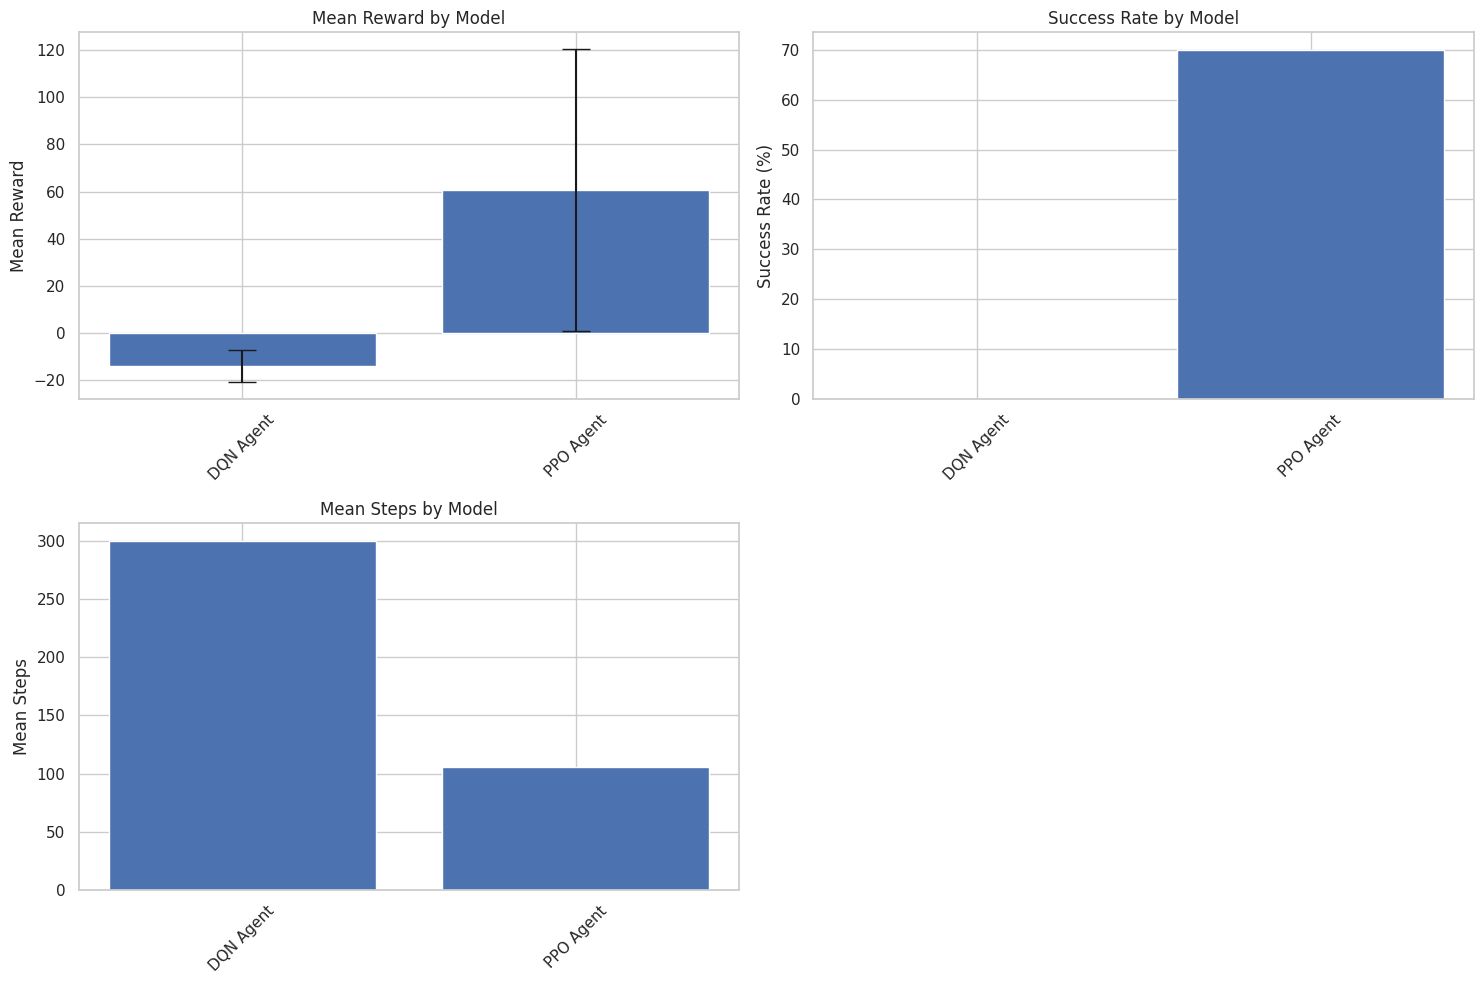


Model: DQN Agent (dqn)
Mean reward: -14.05 ± 6.77
Mean steps: 300.00
Success rate: 0.0%

Model: PPO Agent (ppo)
Mean reward: 60.57 ± 59.88
Mean steps: 105.40
Success rate: 70.0%


In [ ]:
# Define the models to compare
models_info = [
    (dqn_model, "DQN Agent", "dqn"),
    (ppo_model, "PPO Agent", "ppo")
]

# Compare the models
comparison_metrics = compare_models(models_info, mode=dqn_mode, num_episodes=20)

# Print detailed comparison
for metrics in comparison_metrics:
    print(f"\nModel: {metrics['model_name']} ({metrics['model_type']})")
    print(f"Mean reward: {metrics['mean_reward']:.2f} ± {metrics['std_reward']:.2f}")
    print(f"Mean steps: {metrics['mean_steps']:.2f}")
    print(f"Success rate: {metrics['success_rate']*100:.1f}%")

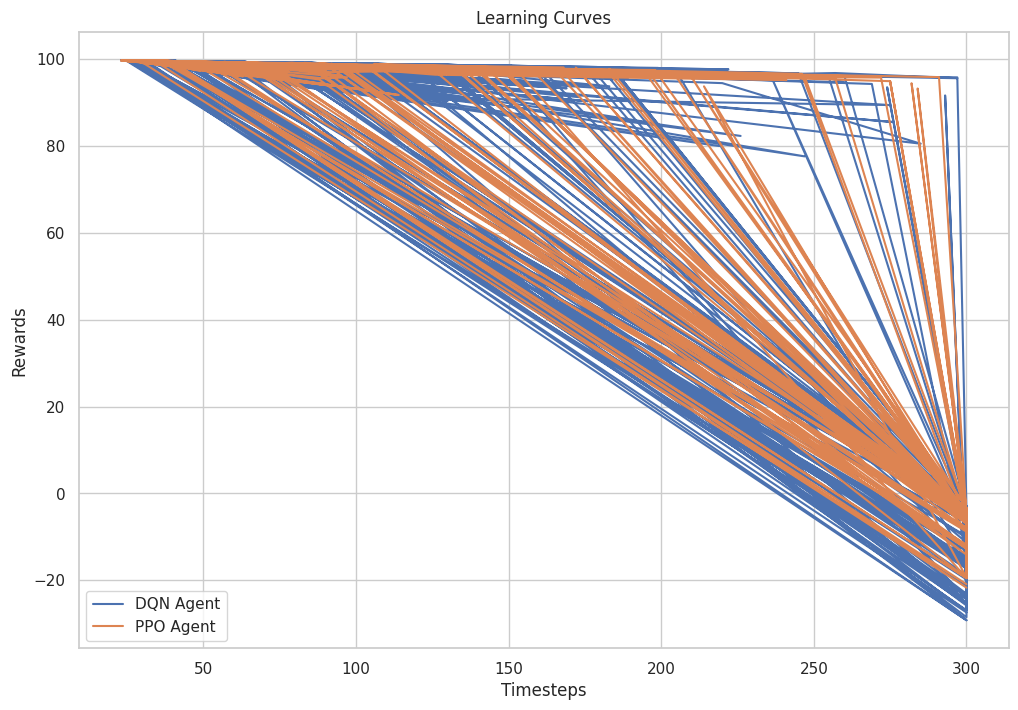

In [ ]:
# Plot Learning Curves
# logs to plot
log_dirs = [
    (dqn_log_dir, "DQN Agent"),
    (ppo_log_dir, "PPO Agent")
]

# Plot learning curves
plot_learning_curves(log_dirs)